## Imports

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from dateutil.relativedelta import relativedelta as rd
from copy import deepcopy
from tqdm import tqdm
import time 

# plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# PCA Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Presentation of the dataset

C:\Users\click\AppData\Local\Temp\ipykernel_2068\2659310674.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('twilight_shifted', len(hist_spot.columns))


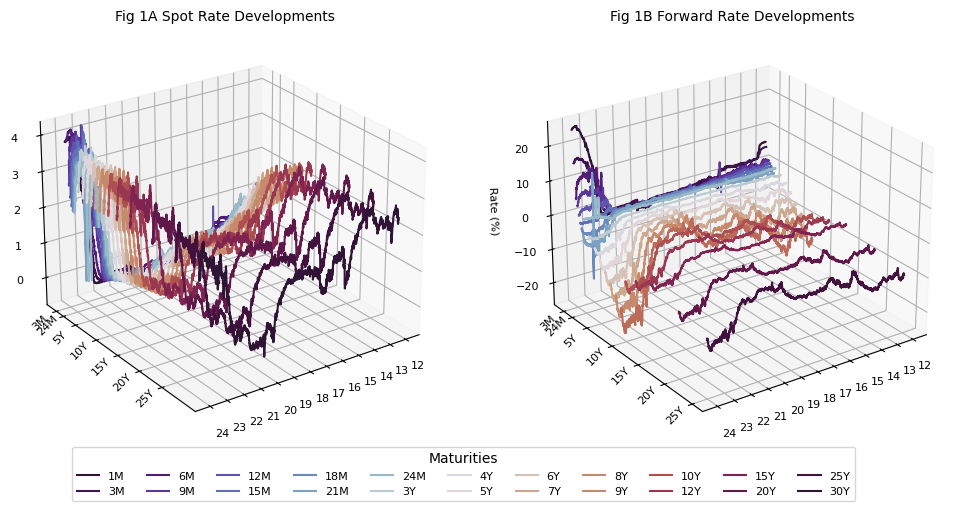

In [12]:
'Load Spot Rates'
# load historical dkk market swap curve - ex. deposit rates for now
dataurl = r'https://github.com/Jakobespi/APF_Seminar/raw/3c3965cb32d034a795cac20fc4e4c26c7f07070d/Data/CurveData.xlsm'
hist_spot = pd.read_excel(dataurl, sheet_name='CurveHist', usecols='A,D:Y', skiprows=2).dropna()
hist_spot['Date'] = pd.to_datetime(hist_spot['Date'])
hist_spot = hist_spot.set_index('Date')

# Convert maturity strings to numerical values (in years)
def maturity_to_years(maturity):
    if 'Y' in maturity:
        return int(maturity.replace('Y', ''))
    elif 'M' in maturity:
        return int(maturity.replace('M', '')) / 12.0
    else:
        return np.nan  # Just in case there are other formats

'Convert to Forward Rates'
hist_fr =  pd.DataFrame()
maturity_values = [maturity_to_years(m) for m in hist_spot.columns]

for idx in range(len(hist_spot.columns) - 1):
    # Define current spot rates and next maturity spot rates
    S_0_M = hist_spot.iloc[:, idx].values
    S_0_M1 = hist_spot.iloc[:, idx + 1].values
    
    # Define delta t between current and next maturity
    delta_t = maturity_values[idx + 1] - maturity_values[idx]
    
    # Calculate forward rate series for maturity M
    F_0_M = 1 / delta_t * (S_0_M1 * (1 + delta_t) - S_0_M * maturity_values[idx])
    
    # Add to the forward rates DataFrame
    hist_fr[hist_spot.columns[idx]] = F_0_M

# Save
# hist_fr.to_excel(r'C:\APF_Seminar\Data\ForwardRates.xlsx')


'Plot Spot and Forward Rates' 
# Define plot params
fig = plt.figure(figsize=(12, 6))

# Set the global font size
plt.rcParams.update({'font.size': 8})

# Plot Spot Rates
ax1 = fig.add_subplot(121, projection='3d')
color_map = plt.cm.get_cmap('twilight_shifted', len(hist_spot.columns))
dates = matplotlib.dates.date2num(hist_spot.index.to_pydatetime())

# Plot each maturity for spot rates
for idx, maturity in enumerate(hist_spot.columns):
    maturity_value = maturity_to_years(maturity)
    maturity_color = color_map(idx / len(hist_spot.columns))
    rates = hist_spot[maturity].values
    ax1.plot(dates, [maturity_value] * len(dates), rates, 
             color=maturity_color, linestyle='-', linewidth=1.5, label=f'{maturity}')

# Title and labels for spot rates
ax1.set_title('Fig 1A Spot Rate Developments', fontsize=10, pad=-80)
ax1.set_zlabel('Rate (%)', fontsize=8)
ax1.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%y'))

# Show specific yticks
specific_labels = ['3M', '24M', '5Y', '10Y', '15Y', '20Y', '25Y']
specific_years = [maturity_to_years(label) for label in specific_labels]
ax1.set_yticks(specific_years)
ax1.set_yticklabels(specific_labels, fontdict={'fontsize':8, 'rotation': 45, 'verticalalignment':'baseline'})
ax1.view_init(elev=25, azim=55)

# Plot Forward Rates
ax2 = fig.add_subplot(122, projection='3d')

# Plot each maturity for forward rates
for idx, maturity in enumerate(hist_fr.columns):
    maturity_value = maturity_to_years(maturity)
    maturity_color = color_map(idx / len(hist_fr.columns))
    rates = hist_fr[maturity].values
    ax2.plot(dates, [maturity_value] * len(dates), rates, 
             color=maturity_color, linestyle='-', linewidth=1.5, label=f'{maturity}')

# Title and labels for forward rates
ax2.set_title('Fig 1B Forward Rate Developments', fontsize=10, pad=-80)
ax2.set_zlabel('Rate (%)', fontsize=8)
ax2.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%y'))

# Show specific yticks
ax2.set_yticks(specific_years)
ax2.set_yticklabels(specific_labels, fontdict={'fontsize':8, 'rotation': 45, 'verticalalignment':'baseline'})
ax2.view_init(elev=25, azim=55)

# Add legend between plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=11, fontsize=8, bbox_to_anchor=(0.5, 0.15), title="Maturities", title_fontsize='10')

# Save the figure
# plt.savefig(r'C:\APF_Seminar\Graphs\spot_and_forward_rates.png', dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

# PCA ANALYSIS

In [13]:
'Load Spot Rates'
# load historical dkk market swap curve - ex. deposit rates for now
dataurl = r'https://github.com/Jakobespi/APF_Seminar/raw/3c3965cb32d034a795cac20fc4e4c26c7f07070d/Data/CurveData.xlsm'
hist_spot = pd.read_excel(dataurl, sheet_name='CurveHist', usecols='A,D:Y', skiprows=2).dropna()
hist_spot['Date'] = pd.to_datetime(hist_spot['Date'])
hist_spot = hist_spot.set_index('Date')

# Convert maturity strings to numerical values (in years)
def maturity_to_years(maturity):
    if 'Y' in maturity:
        return int(maturity.replace('Y', ''))
    elif 'M' in maturity:
        return int(maturity.replace('M', '')) / 12.0
    else:
        return np.nan  # Just in case there are other formats

'Convert to Forward Rates'
hist_fr =  pd.DataFrame(index=hist_spot.index)
maturity_values = [maturity_to_years(m) for m in hist_spot.columns]

for idx in range(len(hist_spot.columns) - 1):
    # Define current spot rates and next maturity spot rates
    S_0_M = hist_spot.iloc[:, idx].values
    S_0_M1 = hist_spot.iloc[:, idx + 1].values
    
    # Define delta t between current and next maturity
    delta_t = maturity_values[idx + 1] - maturity_values[idx]
    
    # Calculate forward rate series for maturity M
    F_0_M = 1 / delta_t * (S_0_M1 * (1 + delta_t) - S_0_M * maturity_values[idx])
    
    # Add to the forward rates DataFrame
    hist_fr[hist_spot.columns[idx]] = F_0_M

# pca func
def perform_pca(data, maturities):
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)
    pca = PCA()
    pca.fit(data_normalized)
    explained_variance_ratio = pca.explained_variance_ratio_
    eigenvalues = pca.explained_variance_
    cum_var = np.cumsum(explained_variance_ratio)
    M = np.argmax(cum_var >= 0.95) + 1

    # Create a DataFrame with eigenvalues and cumulative explained variance for the top M components
    df_pca = pd.DataFrame({
        'Maturity': maturities[:M],
        'Eigenvalue': [round(e,3) for e in eigenvalues[:M]],
        'Explained cumulative variability': [round(cv,3) for cv in cum_var[:M]]
    })

    return pca, M, cum_var, df_pca

'PCA analysis at different cutoffs'
c1 = pd.Timestamp(date(2017, 12, 31))
d_window = hist_fr.loc[:c1, :].diff().dropna()
maturities = hist_fr.columns.tolist()
pca, M, cum_var, df_pca = perform_pca(d_window, maturities)

print(df_pca, '\n\n')

  Maturity  Eigenvalue  Explained cumulative variability
0       1M      10.287                             0.490
1       3M       2.097                             0.589
2       6M       1.915                             0.680
3       9M       1.519                             0.753
4      12M       1.319                             0.816
5      15M       1.017                             0.864
6      18M       0.912                             0.907
7      21M       0.432                             0.928
8      24M       0.407                             0.947
9       3Y       0.359                             0.964 




# Convergence test of Monte Carlo used in backtests

Testing convergence: 100%|██████████| 6/6 [12:14<00:00, 122.43s/it]


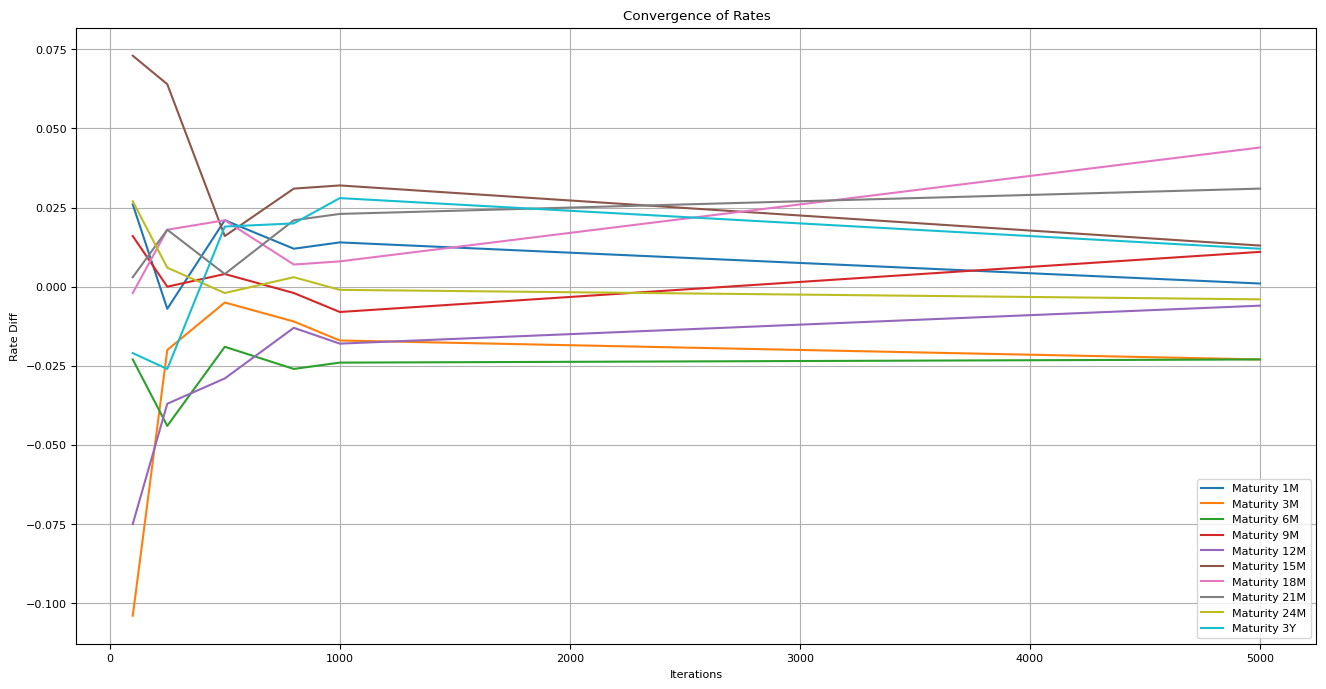

In [14]:

# Load historical data
dataurl = r'https://github.com/Jakobespi/APF_Seminar/raw/3c3965cb32d034a795cac20fc4e4c26c7f07070d/Data/CurveData.xlsm'
hist_fr = pd.read_excel(dataurl, sheet_name='CurveHist', usecols='A,D:Y', skiprows=2).dropna()
hist_fr['Date'] = pd.to_datetime(hist_fr['Date'])
hist_fr = hist_fr.set_index('Date')


# Convert maturity strings to numerical values (in years)
def maturity_to_years(maturity):
    if 'Y' in maturity:
        return int(maturity.replace('Y', ''))
    elif 'M' in maturity:
        return int(maturity.replace('M', '')) / 12.0
    else:
        return np.nan  # Just in case there are other formats

# Define Functions for drift calculation and Monte Carlo simulation
def calc_drift(vol_window, maturity_values):
    M = vol_window.shape[1] - 1
    mu_hats = np.zeros(M)
    for j in range(0, M):
        sum_sigma_k = np.zeros(j + 1)
        for l in range(j):
            sigma_k = vol_window.iloc[-1, l]  # Latest vol value for maturity l
            delta_t_l = maturity_values[l + 1] - maturity_values[l]
            sum_sigma_k[l + 1] = sum_sigma_k[l] + sigma_k * delta_t_l
        delta_t_j = maturity_values[j + 1] - maturity_values[j]
        mu_hat_j = (1 / delta_t_j) * 0.5 * ((sum_sigma_k[j] ** 2) - (sum_sigma_k[j - 1] ** 2))
        mu_hats[j] = mu_hat_j
    return mu_hats

def monte_carlo_simulation_3m(f_rates_t_1, mu_hats, vol_window, num_iterations=100):
    np.random.seed(42)
    M = len(f_rates_t_1)
    T = 63
    dt_i = 1 / 252
    simulated_forward_rates = np.zeros((num_iterations, T, M))
    for n in range(num_iterations):
        f_rates_t_n = f_rates_t_1.copy()
        for t in range(T):
            for j in range(0, M):
                W_ik = np.random.normal(0, 1, M)
                drift_term = mu_hats[j] * dt_i
                sigma_term = np.sum([vol_window.iloc[-1, k] * np.sqrt(dt_i) * W_ik[k] for k in range(M)])
                f_rates_t_n[j] = f_rates_t_n[j] + drift_term + sigma_term
            simulated_forward_rates[n, t, :] = f_rates_t_n
    expected_forward_rates = np.mean(simulated_forward_rates, axis=0).round(4)
    lower_bound = np.percentile(simulated_forward_rates, 2.5, axis=0).round(4)
    upper_bound = np.percentile(simulated_forward_rates, 97.5, axis=0).round(4)
    return expected_forward_rates, lower_bound, upper_bound


'Setup for the test'
# dates and params
M = 10
start_date = pd.Timestamp('2018-01-01')
end_date = hist_fr.index[hist_fr.index >= start_date][63]
forecast_dates = hist_fr.index[(hist_fr.index >= start_date) & (hist_fr.index <= end_date)]

# rates
f_rate_window = hist_fr.loc[:start_date]
f_rate_diff_window = abs(f_rate_window.diff()).dropna()
f_rates_t_1 = np.array(f_rate_window.iloc[-1, :M])
actual_rates = np.array(hist_fr.loc[forecast_dates,hist_fr.columns[:M]])

# vol and drift
vol_window = (f_rate_diff_window.rolling(window=252).std() * np.sqrt(252)).dropna()
maturity_values = [maturity_to_years(m) for m in hist_fr.columns]
mu_hats = calc_drift(vol_window, maturity_values)

# Define the function to test convergence
def test_convergence(f_rates_t_1, mu_hats, vol_window, actual_rates, iteration_steps):
    diffs_3d = np.zeros((len(iteration_steps), len(f_rates_t_1)))
    for idx, num_iterations in enumerate(tqdm(iteration_steps, desc='Testing convergence')):
        exp_f_rates, _, _ = monte_carlo_simulation_3m(f_rates_t_1, mu_hats, vol_window, num_iterations=num_iterations)
        diffs = exp_f_rates[-1, :] - actual_rates[-1, :]  # Compare the last forward rates across all maturities
        diffs_3d[idx, :] = diffs.round(3)
    return diffs_3d


'Test convergence'
iteration_steps = [100, 250, 500, 800, 1000, 5000]
diffs_3d = test_convergence(f_rates_t_1, mu_hats, vol_window, actual_rates, iteration_steps)


'Visualization'
# Create a mapping of maturity values to their names
maturity_names = ['1M', '3M', '6M', '9M', '12M', '15M', '18M', '21M', '24M', '3Y']

# Visualization
plt.figure(figsize=(16, 8))

# Plot convergence of rates for each maturity
for maturity_idx in range(diffs_3d.shape[1]):
    plt.plot(iteration_steps, diffs_3d[:, maturity_idx], label=f'Maturity {maturity_names[maturity_idx]}')

plt.xlabel('Iterations')
plt.ylabel('Rate Diff')
plt.title('Convergence of Rates')
plt.legend()
plt.grid(True)
plt.show()

# Backtesting 3 month forecasts for all maturities (3D plot)

Estimated number of minutes to run entire backtest: 19.333333333333332

Simulation until 2018-04 runtime: 79.77 seconds

Simulation until 2018-07 runtime: 79.54 seconds

Simulation until 2018-10 runtime: 79.31 seconds

Simulation until 2019-01 runtime: 92.00 seconds

Simulation until 2019-04 runtime: 83.55 seconds

Simulation until 2019-07 runtime: 80.22 seconds

Simulation until 2019-10 runtime: 79.54 seconds

Simulation until 2020-01 runtime: 93.52 seconds

Simulation until 2020-04 runtime: 97.28 seconds

Simulation until 2020-07 runtime: 83.44 seconds

Simulation until 2020-10 runtime: 77.11 seconds

Simulation until 2021-01 runtime: 95.68 seconds

Simulation until 2021-04 runtime: 96.62 seconds

Simulation until 2021-07 runtime: 92.10 seconds

Simulation until 2021-10 runtime: 76.88 seconds

Simulation until 2022-01 runtime: 76.18 seconds

Simulation until 2022-04 runtime: 78.60 seconds

Simulation until 2022-07 runtime: 77.36 seconds

Simulation until 2022-10 runtime: 76.06 second

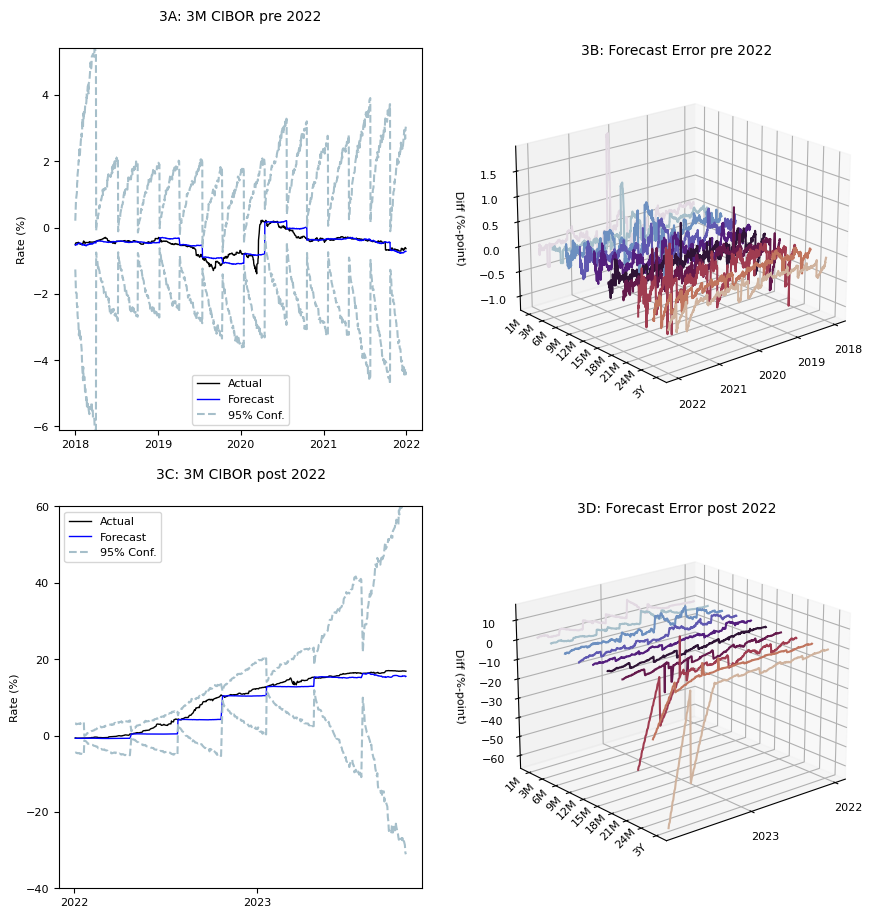

In [15]:
'Load Spot Rates'
# load historical dkk market swap curve - ex. deposit rates for now
dataurl = r'https://github.com/Jakobespi/APF_Seminar/raw/3c3965cb32d034a795cac20fc4e4c26c7f07070d/Data/CurveData.xlsm'
hist_spot = pd.read_excel(dataurl, sheet_name='CurveHist', usecols='A,D:Y', skiprows=2).dropna()
hist_spot['Date'] = pd.to_datetime(hist_spot['Date'])
hist_spot = hist_spot.set_index('Date')

# Convert maturity strings to numerical values (in years)
def maturity_to_years(maturity):
    if 'Y' in maturity:
        return int(maturity.replace('Y', ''))
    elif 'M' in maturity:
        return int(maturity.replace('M', '')) / 12.0
    else:
        return np.nan  # Just in case there are other formats

'Convert to Forward Rates'
hist_fr =  pd.DataFrame(index=hist_spot.index)
maturity_values = [maturity_to_years(m) for m in hist_spot.columns]

for idx in range(len(hist_spot.columns) - 1):
    # Define current spot rates and next maturity spot rates
    S_0_M = hist_spot.iloc[:, idx].values
    S_0_M1 = hist_spot.iloc[:, idx + 1].values
    
    # Define delta t between current and next maturity
    delta_t = maturity_values[idx + 1] - maturity_values[idx]
    
    # Calculate forward rate series for maturity M
    F_0_M = 1 / delta_t * (S_0_M1 * (1 + delta_t) - S_0_M * maturity_values[idx])
    
    # Add to the forward rates DataFrame
    hist_fr[hist_spot.columns[idx]] = F_0_M

# Select 10 components due to pca analysis
M = 10
hist_fr = hist_fr.iloc[:,:M+1]
maturity_values = [maturity_to_years(m) for m in hist_fr.columns]


'Define Functions'

# Function to calculate the drift term and sigma sums
def calc_drift(vol_window, maturity_values):
    M = vol_window.shape[1] - 1
    mu_hats = np.zeros(M)
    for j in range(0, M):
        sum_sigma_k = np.zeros(j + 1)

        for l in range(j):
            sigma_k = vol_window.iloc[-1, l]  # Latest vol value for maturity l
            delta_t_l = maturity_values[l + 1] - maturity_values[l]
            sum_sigma_k[l + 1] = sum_sigma_k[l] + sigma_k * delta_t_l

        delta_t_j = maturity_values[j + 1] - maturity_values[j]
        mu_hat_j = (1 / delta_t_j) * 0.5 * ((sum_sigma_k[j] ** 2) - (sum_sigma_k[j - 1] ** 2))
        mu_hats[j] = mu_hat_j

    return mu_hats

# Monte Carlo simulation function for T days in advance
def monte_carlo_simulation_dT(f_rates_t_1, mu_hats, vol_window, dt_i, T, num_iterations=800):
    
    # Set the seed for reproducibility
    np.random.seed(42)

    # inits
    M = len(f_rates_t_1)
    simulated_forward_rates = np.zeros((num_iterations, T, M))

    # for each iteration calculate expected rates over T days
    for n in range(num_iterations):
        f_rates_t_n = f_rates_t_1.copy()  # Start with the initial forward rates
        for t in range(T):
            for j in range(0, M):
                W_ik = np.random.normal(0, 1, M)  # Generate independent standard normal variables
                drift_term = mu_hats[j] * dt_i
                sigma_term = np.sum([vol_window.iloc[-1, k] * np.sqrt(dt_i) * W_ik[k] for k in range(M)])

                # update initial forward rates at time t-1 for current sim
                f_rates_t_n[j] = f_rates_t_n[j] + drift_term + sigma_term

            simulated_forward_rates[n, t, :] = f_rates_t_n

    # take average of all simulations
    expected_forward_rates = np.mean(simulated_forward_rates, axis=0).round(4)

    # calculate 95% confidence intervals
    lower_bound = np.percentile(simulated_forward_rates, 1, axis=0).round(4)
    upper_bound = np.percentile(simulated_forward_rates, 99, axis=0).round(4)

    return expected_forward_rates, lower_bound, upper_bound

'Backtesting'
# store expected and actual rates for M maturities in df
backtest_exp = hist_fr.loc[:pd.Timestamp(date(2017,12,31)), [c for c in hist_fr.columns if c!= '4Y']]
backtest_lower = deepcopy(backtest_exp)
backtest_upper = deepcopy(backtest_exp)

# start time
total_backtest_start = time.time()

# first forecast start
start_date = pd.Timestamp('2018-01-01')

# forecasting trading days
T = 63

print(f"Estimated number of minutes to run entire backtest: {round(len(hist_fr.index[hist_fr.index >= pd.Timestamp('2018-01-01')]) / 74, 0) *  58 /60}\n")

# backtest
while start_date <= hist_fr.index[-1]:


    'Data window'
    # date inits
    end_date = hist_fr.index[hist_fr.index >= start_date][T-1]
    dt_i = 1/252
    forecast_dates = hist_fr.index[(hist_fr.index >= start_date) & (hist_fr.index <= end_date)]
    sim_end_year = end_date.year

    # window of data up until forecast start
    f_rate_window = hist_fr.loc[:start_date] 
    f_rate_diff_window = abs(f_rate_window.diff()).dropna()

    # define forward rates at time t-1 for M maturities
    f_rates_t_1 = np.array(f_rate_window.iloc[-1,:M])

    'Vol and drift'
    # calculate annualized 1 year rolling vol and estimated drifts for each maturity
    vol_window = (f_rate_diff_window.rolling(window=252).std() * np.sqrt(252) ).dropna()
    mu_hats = calc_drift(vol_window, maturity_values)


    'Monte Carlo Sim'
    # Run Monte Carlo simulation
    sim_start = time.time()
    exp_f_rates, lower_bound, upper_bound = monte_carlo_simulation_dT(f_rates_t_1, mu_hats, vol_window, dt_i, T)
    sim_end = time.time()
    sim_length = abs(sim_start - sim_end)

    print(f"Simulation until {end_date.strftime('%Y-%m')} runtime: {sim_length:.2f} seconds\n")
    
    # save expected forward rates and difference
    exp_res = pd.DataFrame(exp_f_rates, index=forecast_dates, columns=hist_fr.columns[:M])
    backtest_exp = pd.concat([backtest_exp, exp_res])

    # save confidence bands
    lower_res = pd.DataFrame(lower_bound, index=forecast_dates, columns=hist_fr.columns[:M])
    upper_res = pd.DataFrame(upper_bound, index=forecast_dates, columns=hist_fr.columns[:M])
    backtest_lower = pd.concat([backtest_lower, lower_res])
    backtest_upper = pd.concat([backtest_upper, upper_res])


    'Step a day after the end of forecast period to avoid overlapping'
    if end_date >= hist_fr.index[-T]:
        break
    else:
        start_date = hist_fr.index[hist_fr.index >= end_date][1]


# Measure the end time of all foecasts
total_backtest_end = time.time()

# Calculate the elapsed time
total_backtest_run_time = abs(total_backtest_start - total_backtest_end) / 60
print(f"Elapsed time for backtest: {total_backtest_run_time:.2f} minutes\n")


'Analyse forecast vs actual rates'
# format dataframes for visualization
maturity_names = ['1M', '3M', '6M', '9M', '12M', '15M', '18M', '21M', '24M', '3Y']
rate_diffs = (hist_fr[maturity_names] - backtest_exp).round(4)
rate_diffs = rate_diffs.loc[rate_diffs.index >= pd.Timestamp('2018-01-01')].dropna()
backtest_lower = backtest_lower.loc[backtest_lower.index >= pd.Timestamp('2018-01-01')].dropna()
backtest_upper = backtest_upper.loc[backtest_upper.index >= pd.Timestamp('2018-01-01')].dropna()
hist_fr = hist_fr.loc[(hist_fr.index >= pd.Timestamp('2018-01-01')) & (hist_fr.index <= backtest_upper.index.max()), maturity_names].dropna()
backtest_exp = backtest_exp.loc[backtest_exp.index >= pd.Timestamp('2018-01-01')].dropna()

# Define figure params
fig = plt.figure(figsize=(16, 14))
plt.rcParams.update({'font.size': 8})

'Fig A and B, plot actual forward rates and confidence bands'
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
color_map = plt.colormaps.get_cmap('twilight')
cutoff = pd.Timestamp('2022-01-01')
dates_1 = mdates.date2num(hist_fr.index[hist_fr.index < cutoff].to_pydatetime())
dates_2 = mdates.date2num(hist_fr.index[hist_fr.index >= cutoff].to_pydatetime())
udvalgt_ms = ['3M']

# Plot each maturity
for idx, maturity in enumerate(udvalgt_ms):
    maturity_color = color_map(idx+1 / len(rate_diffs.columns)) 
    
    # Plot actual rates
    ax1.plot(dates_1, hist_fr.loc[hist_fr.index < cutoff, maturity].values, color='black', linestyle='-', linewidth=1, label='Actual')
    ax2.plot(dates_2, hist_fr.loc[hist_fr.index >= cutoff, maturity].values, color='black', linestyle='-', linewidth=1, label = 'Actual')
    
    # Plot expected rates
    ax1.plot(dates_1, backtest_exp.loc[backtest_exp.index < cutoff, maturity].values, color='blue', linestyle='-', linewidth=1, label='Forecast')
    ax2.plot(dates_2, backtest_exp.loc[backtest_exp.index >= cutoff, maturity].values, color='blue', linestyle='-', linewidth=1, label = 'Forecast')

    # Plot confidence bands
    ax1.plot(dates_1, backtest_lower.loc[backtest_lower.index < cutoff, maturity].values, color=maturity_color, linestyle='--', linewidth=1.5, label = '95% Conf.')
    ax1.plot(dates_1, backtest_upper.loc[backtest_upper.index < cutoff, maturity].values, color=maturity_color, linestyle='--', linewidth=1.5)
    ax2.plot(dates_2, backtest_lower.loc[backtest_lower.index >= cutoff, maturity].values, color=maturity_color, linestyle='--', linewidth=1.5, label = '95% Conf.')
    ax2.plot(dates_2, backtest_upper.loc[backtest_upper.index >= cutoff, maturity].values, color=maturity_color, linestyle='--', linewidth=1.5)

# Title and labels for forward rates
ax1.set_title('3A: 3M CIBOR pre 2022', fontsize=10, pad=20)
ax1.set_ylabel('Rate (%)', fontsize=8)
ax2.set_title('3C: 3M CIBOR post 2022', fontsize=10, pad=20)
ax2.set_ylabel('Rate (%)', fontsize=8)

# Format the x-axis with yearly ticks
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Calculate the dynamic ylim
ylim_min_1 = min(hist_fr.loc[hist_fr.index < cutoff, maturity].values.min(), 
                 backtest_lower.loc[backtest_lower.index < cutoff, maturity].values.min(), 
                 backtest_upper.loc[backtest_upper.index < cutoff, maturity].values.min())

ylim_max_1 = max(hist_fr.loc[hist_fr.index < cutoff, maturity].values.max(), 
                 backtest_lower.loc[backtest_lower.index < cutoff, maturity].values.max(), 
                 backtest_upper.loc[backtest_upper.index < cutoff, maturity].values.max()
                 )

# Show specific yticks with maturity names
ax1.set_ylim([ylim_min_1, ylim_max_1])
ax2.set_ylim([-40, 60])

# Add legend for confidence bands
ax1.legend()
ax2.legend()


'Fig C and D, Plot rate_diffs'
ax3 = fig.add_subplot(222, projection='3d', position=[0.55, 0.55, 0.5, 0.5])
ax4 = fig.add_subplot(224, projection='3d', position=[0.55, 0.05, 0.5, 0.5])

# Plot each maturity
for idx, maturity in enumerate(rate_diffs.columns):
    maturity_color = color_map(idx / len(rate_diffs.columns))
    diffs_pre_2021 = rate_diffs.loc[rate_diffs.index < cutoff, maturity].values
    diffs_post_2021 = rate_diffs.loc[rate_diffs.index >= cutoff, maturity].values
    ax3.plot(dates_1, [idx] * len(dates_1), diffs_pre_2021, 
             color=maturity_color, linestyle='-', linewidth=1.5)
    ax4.plot(dates_2, [idx] * len(dates_2), diffs_post_2021, 
             color=maturity_color, linestyle='-', linewidth=1.5)

# Title and labels for forward rates
ax3.set_title('3B: Forecast Error pre 2022', fontsize=10, pad=-150)
ax3.set_zlabel('Diff (%-point)', fontsize=8)
ax4.set_title('3D: Forecast Error post 2022', fontsize=10, pad=-150)
ax4.set_zlabel('Diff (%-point)', fontsize=8)

# Format the x-axis with yearly ticks
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Show specific yticks with maturity names
ax3.set_yticks(range(len(maturity_names)))
ax3.set_yticklabels(maturity_names, fontdict={'fontsize':8, 'rotation': 45, 'verticalalignment':'baseline'})
ax3.view_init(elev=20, azim=50)
ax4.set_yticks(range(len(maturity_names)))
ax4.set_yticklabels(maturity_names, fontdict={'fontsize':8, 'rotation': 45, 'verticalalignment':'baseline'})
ax4.view_init(elev=20, azim=50)

# Save the figure
plt.subplots_adjust(left=0.3, right=0.8, top=0.7, bottom=0.1)
# plt.savefig(r'C:\APF_Seminar\Graphs\Backtest_99Conf.png', dpi=300, bbox_inches='tight')
plt.show()